# MMotion

A notebook used for training and testing models used in the characterisation of human motion with milimeter wave (mmWave) and image sensor fusion

## File Manipulation

In [ ]:
# Mount google drive and define locations of dataset used for mmotion
from google.colab import drive, files
import os, sys

drive.mount("/content/drive", force_remount=True)
root_dir = "/content/drive/MyDrive/mMotion/"
local_root_dir = "/content/mMotion/"

original_data_dir = os.path.join(root_dir, "Data/")
working_dir = os.path.join(root_dir, "notebooks/")
hupr_dir = os.path.join(working_dir, "data/hupr")
hupr_image_dir = os.path.join(hupr_dir, "image") # original image data location
hupr_radar_dir = os.path.join(hupr_dir, "radar") # original radar data location


Mounted at /content/drive


In [ ]:
# !cp -r "/content/drive/MyDrive/mMotion/notebooks/data/hupr/stand-walk-radar" "/content/"
!rsync -ah --progress "/content/drive/MyDrive/mMotion/notebooks/data/hupr/stand-walk-radar/" "/content/stand-walk-radar"


In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (320 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120831 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree /content/drive/MyDrive/mMotion/notebooks/data/hupr/stand-walk-radar/test

/content/drive/MyDrive/mMotion/notebooks/data/hupr/stand-walk-radar/test
├── standing
└── walking

2 directories, 0 files


In [ ]:
!nvidia-smi

Sun Aug 20 20:48:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    26W /  70W |  14675MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
import zipfile

# Unzip each compressed file in source dir and copy the contents to a new dir with the same name in a dest dir
def extract_hupr_images(src_dir, dest_dir):
    print(src_dir)
    print(dest_dir)

    for f in os.listdir(src_dir):
        filename = f.split(".")
        if filename[1] == "zip" and not os.path.isdir(f"{dest_dir}/{filename[0]}"):
            print(f"Unizipping {src_dir}/{f} to {dest_dir}/{filename[0]}")
            with zipfile.ZipFile(f"{src_dir}/{f}", 'r') as f:
                f.extractall(f"{dest_dir}/{filename[0]}")


# src = os.path.join(original_data_dir, "HuPR/frames") # Uncomment to unzip hupr data
# extract_hupr_images(src, hupr_image_dir)

In [ ]:
from pathlib import Path
from shutil import copyfile, copy
from distutils.dir_util import copy_tree

# Build the directory structure for training a model that is able to identify participants in the HuPR dataset
# Takes a source dir (location of hupr frames) and a dictionary with keys=participant_id and values=training frames associated with participant
# Dir structure should be as follows:
# root
#   --------train
#   ------------class_1
#   ------------class_2
#   ------------class_3
#   --------validate
#   ------------class_1
#   ------------class_2
#   ------------class_3
#   --------test
#   ------------class_1
#   ------------class_2
#   ------------class_3

# Create 2 class folders that will contain all instances of their respective class
# Create 3 directories for train validate and test data
def init_dirs(src_dir, run_dir, class_samples):
    # run_dir = os.path.join(src_dir, "biometric")
    Path(run_dir).mkdir(parents=True, exist_ok=True)
    Path(run_dir+"/train").mkdir(parents=True, exist_ok=True)
    Path(run_dir+"/validate").mkdir(parents=True, exist_ok=True)
    Path(run_dir+"/test").mkdir(parents=True, exist_ok=True)

    for cls in class_samples.keys():
        print(f"Creating dir {run_dir}/{cls}")
        Path(run_dir+"/"+cls).mkdir(parents=True, exist_ok=True)
        Path(run_dir+"/train/"+cls).mkdir(parents=True, exist_ok=True)
        Path(run_dir+"/validate/"+cls).mkdir(parents=True, exist_ok=True)
        Path(run_dir+"/test/"+cls).mkdir(parents=True, exist_ok=True)

# Build the directory structure required for using a flow from directory type of data generator
def build_class_dirs(src_dir, dest_dir, participants, data_type="image"):
    print("Creating dir structure for ML data")
    for p in participants.keys():
        print(p)
        for frame in participants[p]:
            if data_type == "radar":
                for f in os.listdir(f"{src_dir}/{frame}/hori"):
                    f_path = os.path.join(f"{src_dir}/{frame}/hori", f)
                    print(f_path)
                    print(os.path.exists(f_path))
                    copy(f_path, f"{dest_dir}/{p}/hori_{frame}_{f}")
                    # print(f"Copy {src_dir}/{frame} to {dest_dir}/{p}")
                    # copy_tree(f"{src_dir}/{frame}", f"{dest_dir}/{p}")
            else:
                for f in os.listdir(f"{src_dir}/{frame}"):
                    f_path = os.path.join(f"{src_dir}/{frame}", f)
                    copy(f_path, f"{dest_dir}/{p}/{frame}_{f}")
                    # print(f"Copy {src_dir}/{frame} to {dest_dir}/{p}")
                    # copy_tree(f"{src_dir}/{frame}", f"{dest_dir}/{p}")

# Get a portion of data from each of the classes and put it the the appropriate dir
def split_data(run_dir, class_samples):
    train_split = .5
    validate_split = .25
    test_split = .25
    for cls in class_samples.keys():
        class_samples[cls] = os.listdir(run_dir+"/"+cls)
        num_samples = len(class_samples[cls])
        train_start = 0
        train_end = int(num_samples * train_split)
        validate_start = int(train_end )
        validate_end = int(validate_start + (num_samples * validate_split))
        test_start = int(validate_end )
        test_end = int(test_start + (num_samples * test_split))
        print("{} class {} samples".format(num_samples, cls))
        print(f"{cls} training samples {train_start} to {train_end}")
        print(f"{cls} validate samples {validate_start} to {validate_end}")
        print(f"{cls} test samples {test_start} to {test_end}")

        for i in range(train_start, train_end):
            print(f"Copying {run_dir}/{cls}/{class_samples[cls][i]} to {run_dir}/train/{cls}/{class_samples[cls][i]}")
            if not os.path.exists(run_dir+"/train/"+cls+"/"+class_samples[cls][i]):
                copyfile(run_dir+"/"+cls+"/"+class_samples[cls][i], run_dir+"/train/"+cls+"/"+class_samples[cls][i])

        for i in range(validate_start, validate_end):
            print(f"Copying {run_dir}/{cls}/{class_samples[cls][i]} to {run_dir}/train/{cls}/{class_samples[cls][i]}")
            if not os.path.exists(run_dir+"/validate/"+cls+"/"+class_samples[cls][i]):
                copyfile(run_dir+"/"+cls+"/"+class_samples[cls][i], run_dir+"/validate/"+cls+"/"+class_samples[cls][i])

        for i in range(test_start, test_end):
            print(f"Copying {run_dir}/{cls}/{class_samples[cls][i]} to {run_dir}/train/{cls}/{class_samples[cls][i]}")
            if not os.path.exists(run_dir+"/test/"+cls+"/"+class_samples[cls][i]):
                copyfile(run_dir+"/"+cls+"/"+class_samples[cls][i], run_dir+"/test/"+cls+"/"+class_samples[cls][i])

run_dir_image = os.path.join(hupr_dir, "biometric") # Run dir for image models
run_dir_radar = os.path.join(hupr_dir, "biometric-radar")
run_dir_sdwk_radar = os.path.join(hupr_dir, "stand-walk-radar")
run_dir_sdwk_image = os.path.join(hupr_dir, "stand-walk-image")


# Dictionary where keys are class labels (participant ID) and values are lists of frames associated with said participant
participant_frames = {
    "participant_1": ["single_5", "single_6", "single_26", "single_28"],
    "participant_2": ["single_57", "single_58", "single_8", "single_10"],
    "participant_3": ["single_40", "single_38", "single_39", "single_15"],
}

# # Dictionary where keys are class labels for a walking-standing binary classifier - IDEAL setup
# standing_walking_frames = {
#     "standing": ["single_1", "single_36", "single_40", "single_60"],
#     "waling": ["single_7", "single_8", "single_38", "single_64"]
# }

# Dictionary where keys are class labels for a walking-standing binary classifier
standing_walking_frames = {
    "standing": ["single_5", "single_40", "single_57", "single_58"],
    "walking": ["single_8", "single_10", "single_26", "single_38"]
}



In [ ]:
# Copy files and do data split for biometric Image classifier
# init_dirs(hupr_dir, "biometric", ["participant_1", "participant_2", "participant_3"]) # Uncomment to build directory structure
# build_class_dirs(hupr_image_dir, run_dir, participant_frames) # Uncomment to copy images
# split_data(run_dir, participant_frames) # Uncomment to perform data split

In [ ]:
# Copy files and do data split for biometric radar classifier
# init_dirs(hupr_dir, run_dir_radar, participant_frames) # Uncomment to build directory structure
# build_class_dirs(hupr_radar_dir, run_dir_radar, participant_frames, "radar") # Uncomment to copy radar npy data
# split_data(run_dir_radar, participant_frames) # Uncomment to perform data split

In [ ]:
# Copy files and do data split for standing or walking radar classifier
# init_dirs(hupr_dir, run_dir_sdwk_radar, standing_walking_frames) # Uncomment to build directory structure
# build_class_dirs(hupr_radar_dir, run_dir_sdwk_radar, standing_walking_frames, "radar") # Uncomment to copy radar npy data
# split_data(run_dir_sdwk_radar, standing_walking_frames) # Uncomment to perform data split

In [ ]:
# Copy files and do data split for standing or walking image classifier
# init_dirs(hupr_dir, run_dir_sdwk_image, standing_walking_frames) # Uncomment to build directory structure
# build_class_dirs(hupr_image_dir, run_dir_sdwk_image, standing_walking_frames, "image") # Uncomment to copy radar npy data
# split_data(run_dir_sdwk_image, standing_walking_frames) # Uncomment to perform data split

## Data Sanity Tests

/content/drive/MyDrive/mMotion/notebooks/data/hupr/biometric/train/participant_1/single_5_000000000.jpg
(512, 512, 3)


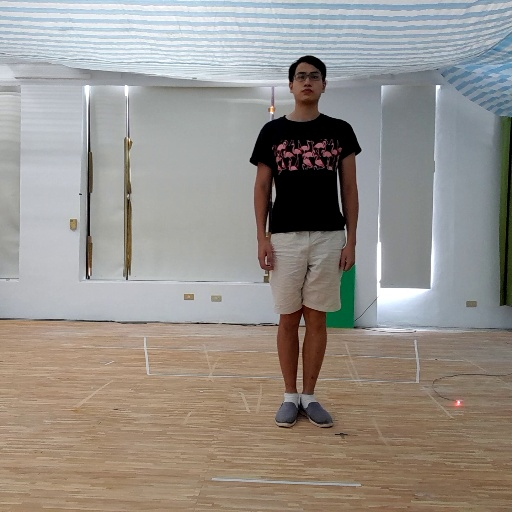

(200, 200, 3)


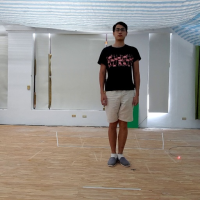

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
# Check image data
test_img_path = os.path.join(hupr_dir, "biometric/train/participant_1/single_5_000000000.jpg")
print(test_img_path)
image = cv2.imread(test_img_path)
print(image.shape)
cv2_imshow(image)

# Resized image
resized = cv2.resize(image, (200, 200), interpolation = cv2.INTER_AREA)
print(resized.shape)
cv2_imshow(resized)


In [ ]:
import cv2

# Check radar data
test_radar_hori_path = os.path.join(hupr_dir, "radar/single_5/hori/000000000.npy")
print(test_radar_hori_path)
radar_hori = np.load(test_radar_hori_path, allow_pickle=True)
print(radar_hori.shape)
print(type(radar_hori))
# print(radar_hori)

test_radar_vert_path = os.path.join(hupr_dir, "radar/single_5/vert/000000000.npy")
print(test_radar_vert_path)
radar_vert = np.load(test_radar_vert_path, allow_pickle=True)
print(radar_vert.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((radar_vert,radar_hori)).batch(4)
print(train_dataset)



/content/drive/MyDrive/mMotion/notebooks/data/hupr/radar/single_5/hori/000000000.npy


NameError: ignored

In [ ]:
# Data sanity tests
# Get the total number of samples in train validate and test
def get_n_samples(run_dir, classes):
    ntrain_samples = 0
    nvalidate_samples = 0
    ntest_samples = 0

    for class_name in classes.keys():
        ntrain_samples += len(os.listdir(run_dir+"/train/"+class_name))
        nvalidate_samples += len(os.listdir(run_dir+"/validate/"+class_name))
        ntest_samples += len(os.listdir(run_dir+"/test/"+class_name))

    print("Number of training samples = {}\nNumber of validation samples = {}\nNumber of testing samples = {}\n".format(ntrain_samples, nvalidate_samples, ntest_samples))

# This function ensures that there were no errors in the data splitting such that an image is more than 1 set
def build_sample_set(dir, s):
    for sample in os.listdir(dir):
        s.add(sample)

# Use set operations to make sure there are no intersections between datasets
def check_data_leaks(run_dir, classes):
    train_samples = set()
    validate_samples = set()
    test_samples = set()

    for class_name in classes.keys():
        build_sample_set(run_dir+"/train/"+class_name, train_samples)
        build_sample_set(run_dir+"/validate/"+class_name, validate_samples)
        build_sample_set(run_dir+"/test/"+class_name, test_samples)

    print("Intersection between train and validate: {}".format(not train_samples.isdisjoint(validate_samples)))
    print("Intersection between train and test:     {}".format(not train_samples.isdisjoint(test_samples)))
    print("Intersection between test and validate:  {}".format(not test_samples.isdisjoint(validate_samples)))

run_dir = os.path.join(hupr_dir, "stand-walk-radar/dataset")
# participant_frames = {
#     "participant_1": ["single_5", "single_6", "single_26", "single_28"],
#     "participant_2": ["single_57", "single_58", "single_8", "single_10"],
#     "participant_3": ["single_40", "single_38", "single_39", "single_15"],
# }
standing_walking_frames = {
    "standing": ["single_5", "single_40", "single_57", "single_58"],
    "walking": ["single_8", "single_10", "single_26", "single_38"]
}

# Should match split defined in split_data
get_n_samples(run_dir, standing_walking_frames)
# If all are false then there are no interesections/data leaks
check_data_leaks(run_dir, standing_walking_frames)

## ML Setup

In [ ]:
# Imports required for core functionality
from time import time
from datetime import datetime
import numpy as np
import pandas as pd

# Graphing tools
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# CNN components
import tensorflow as tf
tf.__version__
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dropout, BatchNormalization, Activation, LSTM, Reshape, TimeDistributed, GRU, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

RADAR_DATA_SHAPE = (16, 64, 64, 16)
RADAR_NUM_CLASSES = 1


In [ ]:
# Preprocess images to use in the CNN - only used in basic model, better to use data augmentation
def stage_train_data(target_size, batch_size, class_mode, train_dir, validate_dir):
    train_datagen = ImageDataGenerator(rescale=1./255)
    validate_datagen = ImageDataGenerator(rescale=1./255)

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    validate_gen = validate_datagen.flow_from_directory(
        validate_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    return train_gen, validate_gen

In [ ]:
# Preprocess images and apply data augmentation to the train data
# Transformations to be applied: rotation, shift, shear, zoom, horizontal flip
def augment_train_data(target_size, batch_size, class_mode, train_dir, validate_dir):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=25,
        height_shift_range=0.15,
        width_shift_range=0.15,
        horizontal_flip=True,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest"
    )

    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode,

    )

    # No augmentation to be done to validation data
    validate_datagen = ImageDataGenerator(rescale=1./255)
    validate_gen = validate_datagen.flow_from_directory(
        validate_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode
    )

    return train_gen, validate_gen

In [ ]:
# Code for staging training data for radar CNNs

def set_shapes(tensor, label_tensor, data_shape, label_shape):
    tensor.set_shape(data_shape)
    label_tensor.set_shape(label_shape)
    return tensor, label_tensor

# Returns list of samples and corresponding labels
def get_files_labels(radar_data_dir):
    class_labels = sorted(os.listdir(radar_data_dir))
    file_paths = []
    labels = []

    for i, label in enumerate(class_labels):
        label_folder = os.path.join(radar_data_dir, label)
        sorted_files = sorted(os.listdir(label_folder))  # Sorting the filenames
        for file_name in sorted_files:
            if file_name.endswith('.npy'):
                file_path = os.path.join(label_folder, file_name)
                file_paths.append(file_path)
                labels.append(i)

    return file_paths, labels

def load_and_preprocess_radar(file_path, label):
    file_path_str = file_path.numpy().decode('utf-8')   # Decode the EagerTensor to a string
    data_complex = np.load(file_path_str)

    # Splitting into real and imaginary parts
    data_real = data_complex.real
    data_imag = data_complex.imag

    # Flattening the two parts along the last axis
    data = np.concatenate([data_real, data_imag], axis=-1) # Maybe uncomment
    # data = np.stack([data_real, data_imag], axis=-1)


    one_hot_label = tf.one_hot(label, depth=RADAR_NUM_CLASSES)  # Depth is num classes
    return data, one_hot_label

def build_dataset(file_paths, labels, batch_size, num_classes=RADAR_NUM_CLASSES, ):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    data_shape = RADAR_DATA_SHAPE
    label_shape = (num_classes)

    dataset = dataset.map(
        lambda file, label: tf.py_function(
            func=load_and_preprocess_radar,
            inp=[file, label],
            Tout=[tf.float32, tf.float32]
        ),
        # Optimise data loading
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.map(lambda data, label: set_shapes(data, label, data_shape, label_shape))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
# Code for staging training data for radar CNN with RNN classifier

SEQUENCE_LENGTH = 5  # replace 5 with your desired sequence length

def set_shapes_rnn(tensor, label_tensor, data_shape, label_shape=()):
    if RADAR_NUM_CLASSES > 1:
        label_shape = (RADAR_NUM_CLASSES,)
    else:
        label_shape = ()
    tensor.set_shape(data_shape)
    label_tensor.set_shape(label_shape)
    return tensor, label_tensor

# Returns list of samples and corresponding labels
def get_files_labels_rnn(radar_data_dir):
    class_labels = sorted(os.listdir(radar_data_dir))
    file_paths = []
    labels = []

    for i, label in enumerate(class_labels):
        label_folder = os.path.join(radar_data_dir, label)
        sorted_files = sorted(os.listdir(label_folder))  # Sorting the filenames
        for idx, file_name in enumerate(sorted_files[:-SEQUENCE_LENGTH+1]):  # adjusted the loop to prevent overflow
            if file_name.endswith('.npy'):
                # collect sequence file paths
                sequence_paths = [os.path.join(label_folder, sorted_files[idx+j]) for j in range(SEQUENCE_LENGTH)]
                file_paths.append(sequence_paths)
                labels.append(i)  # assuming each sequence has one label

    return file_paths, labels

def load_and_preprocess_radar_rnn(sequence_paths, label):
    sequence_data = []
    for file_path in sequence_paths:
        file_path_str = file_path.numpy().decode('utf-8')
        data_complex = np.load(file_path_str)

        # Splitting into real and imaginary parts
        data_real = data_complex.real
        data_imag = data_complex.imag

        # Flattening the two parts along the last axis
        data = np.concatenate([data_real, data_imag], axis=-1)
        sequence_data.append(data)

    sequence_data = np.stack(sequence_data, axis=0)

    # If multi class do one hot encoding
    if RADAR_NUM_CLASSES > 1:
        one_hot_label = tf.one_hot(label, depth=RADAR_NUM_CLASSES)
        return sequence_data, one_hot_label

    # If bin class just return label
    else:
        return sequence_data, label

def build_dataset_rnn(file_paths, labels, batch_size, num_classes=RADAR_NUM_CLASSES):
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    data_shape = (SEQUENCE_LENGTH, *RADAR_DATA_SHAPE)  # adjusted shape to include sequence length
    if num_classes > 1:
        label_shape = (num_classes)

    # If multi class
    if RADAR_NUM_CLASSES > 1:
        dataset = dataset.map(
            lambda sequence, label: tf.py_function(
            func=load_and_preprocess_radar_rnn,
            inp=[sequence, label],
            Tout=[tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(lambda data, label: set_shapes_rnn(data, label, data_shape, label_shape))

    # If bin classifier
    else:
        dataset = dataset.map(
            lambda sequence, label: tf.py_function(
            func=load_and_preprocess_radar_rnn,
            inp=[sequence, label],
            Tout=[tf.float32, tf.int32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.map(lambda data, label: set_shapes_rnn(data, label, data_shape))

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

## Model Configs

In [ ]:
def baseline_image_bin_cnn(hyperparameters):
    model = Sequential()
    # Input Layer
    model.add(Conv2D(
        32,
        (3, 3),
        activation="relu",
        strides=hyperparameters["strides"],
        dilation_rate=hyperparameters["dialation_rate"],
        input_shape=hyperparameters["input_shape"]
        ))

    # Hidden Layers
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", strides=(1, 1), dilation_rate=1,))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu", strides=(1, 1), dilation_rate=1,))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu", strides=(1, 1), dilation_rate=1,))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    # Output Layer
    model.add(Dense(1, activation="sigmoid"))

    return model

In [ ]:
def baseline_image_multi_cnn(hyperparameters):
    model = Sequential()
    # Input Layer
    model.add(Conv2D(32, (3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], input_shape=hyperparameters["input_shape"]))

    # Hidden Layers
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"],))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"],))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"],))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation="relu"))
    # Output Layer
    model.add(Dense(3, activation="softmax"))
    print("Built multi-class image cnn")

    return model

In [ ]:
def baseline_radar_bin_cnn(hyperparameters):
    model = Sequential()
    # Input Layer - using conv3d as radar is volumetric
    model.add(Conv3D(32, (3, 3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], input_shape=hyperparameters["input_shape"], padding="same"))

    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # Hidden Layers
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Conv3D(64, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Conv3D(128, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Conv3D(128, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    # Output Layer
    model.add(Dense(1, activation="sigmoid"))

    return model

In [ ]:
def baseline_radar_multi_cnn(hyperparameters):
    model = Sequential()
    # Input Layer - using conv3d as radar is volumetric
    model.add(Conv3D(32, (3, 3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], input_shape=hyperparameters["input_shape"], padding="same"))

    # Hidden Layers
    model.add(MaxPooling3D(hyperparameters["pooling"]))
    model.add(Conv3D(64, (3, 3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))
    model.add(Conv3D(128, (3, 3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))
    model.add(Conv3D(128, (3, 3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation="relu"))
    model.add(BatchNormalization(synchronized=True))
    # Output Layer
    model.add(Dense(3, activation="softmax"))


    return model

In [ ]:
# CNN with LSTM classifier and 3 dense layers
def radar_bin_cnn_lstm(hyperparameters):
    model = Sequential()
    # Input Layer - using conv3d as radar is volumetric
    model.add(Conv3D(32, (3, 3, 3), activation="relu", strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], input_shape=hyperparameters["input_shape"], padding="same"))

    model.add(BatchNormalization())
    model.add(Activation("relu"))

    # Hidden Layers
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Conv3D(64, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Conv3D(128, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Conv3D(128, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling3D(hyperparameters["pooling"]))

    model.add(Reshape((16, -1)))  # First value of reshape should be sequential element of LSTM

    # LSTM Layer
    model.add(LSTM(128, return_sequences=False))

    # model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(512))
    model.add(Dropout(0.5))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    # Output Layer
    model.add(Dense(1, activation="sigmoid"))

    return model

In [ ]:
# CNN with GRU classifier and 3 dense layers
def radar_bin_cnn_gru(hyperparameters):
    cnn_input = Input(shape=(16, 64, 64, 16))
    x = Conv3D(32, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same")(cnn_input)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling3D(hyperparameters["pooling"])(x)

    x = Conv3D(64, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same")(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling3D(hyperparameters["pooling"])(x)

    x = Conv3D(128, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same")(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling3D(hyperparameters["pooling"])(x)

    x = Conv3D(128, (3, 3, 3), strides=hyperparameters["strides"], dilation_rate=hyperparameters["dialation_rate"], padding="same")(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling3D(hyperparameters["pooling"])(x)

    cnn_output = Flatten()(x)
    cnn_model = Model(inputs=cnn_input, outputs=cnn_output)

    rnn_input = Input(shape=(5, 16, 64, 64, 16))
    x = TimeDistributed(cnn_model)(rnn_input)
    x = GRU(64, return_sequences=False)(x)

    # model.add(Flatten())
    dense = Sequential()
    dense.add(Dropout(0.5))
    dense.add(Dense(512))
    dense.add(Dropout(0.5))
    dense.add(Dense(512))
    dense.add(Dropout(0.5))
    dense.add(Dense(256))
    dense.add(BatchNormalization())
    dense.add(Activation("relu"))
    # Output Layer
    dense.add(Dense(1, activation="sigmoid"))

    model = Model(inputs=rnn_input, outputs=x)

    return model

In [ ]:
# Show summary of model and plot model structure
def show_model(model):
    K.clear_session()
    print(model.summary(line_length=100))
    plot_model(model, "baseline-model.png", show_shapes=True, show_layer_names=True)

test_hparams_radar = {
    "input_shape": (16, 64, 64, 16),
    # "input_shape": (5, 16, 64, 64, 16),
    "dialation_rate": 1,
    "strides": (1, 1, 1),
    "pooling": (2, 2, 1)
}

test_hparams_image = {
    "input_shape" :(200, 200, 3),
    "dialation_rate": 1,
    "strides": (1, 1)
}

# test_model = baseline_radar_multi_cnn(test_hparams_radar)
# test_model = baseline_image_multi_cnn(test_hparams_image)
test_model = radar_bin_cnn_lstm(test_hparams_radar)

show_model(test_model)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv3d (Conv3D)                             (None, 16, 64, 64, 32)                  13856          
                                                                                                    
 batch_normalization (BatchNormalization)    (None, 16, 64, 64, 32)                  128            
                                                                                                    
 activation (Activation)                     (None, 16, 64, 64, 32)                  0              
                                                                                                    
 max_pooling3d (MaxPooling3D)                (None, 8, 32, 64, 32)                   0              
                                                                       

## Model Fitting

In [ ]:
# Build and compile the model
# TODO switch to the TPU runtime and tune the "steps_per_execution" parameter in compile()
def build_model(model_name, hyperparameters):
    print("Building model")
    # Build baseline binary classification model
    if model_name == "baseline_image_bin_cnn":
        model = baseline_image_bin_cnn(hyperparameters)
        print("Built binary-class image cnn")
        print("Compiling model")
        model.compile(loss="binary_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"], steps_per_execution=8)
        print("Model compilation complete")
        return model
    elif model_name == "baseline_image_multi_cnn":
        model = baseline_image_multi_cnn(hyperparameters)
        print("Model build complete")
        print("Compiling model")
        model.compile(loss="categorical_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"], steps_per_execution=8)
        print("Model compilation complete")
        return model
    elif model_name == "baseline_radar_bin_cnn":
        model = baseline_radar_bin_cnn(hyperparameters)
        print("Built binary-class radar cnn")
        print("Compiling model")
        model.compile(loss="binary_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"], steps_per_execution=8)
        print("Model compilation complete")
        return model
    elif model_name == "baseline_radar_multi_cnn":
        model = baseline_radar_multi_cnn(hyperparameters)
        print("Built multi-class radar cnn")
        print("Compiling model")
        model.compile(loss="categorical_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"], steps_per_execution=8)
        print("Model compilation complete")
        return model
    elif model_name == "radar_bin_cnn_lstm":
        model = radar_bin_cnn_lstm(hyperparameters)
        print("Built bin-class radar cnn w/ lstm")
        print("Compiling model")
        model.compile(loss="binary_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"], steps_per_execution=1)
        print("Model compilation complete")
        return model
    elif model_name == "radar_bin_cnn_gru":
        model = radar_bin_cnn_gru(hyperparameters)
        print("Built bin-class radar cnn w/ gru")
        print("Compiling model")
        model.compile(loss="binary_crossentropy", optimizer=hyperparameters["optimizer"], metrics=["accuracy"], steps_per_execution=1)
        print("Model compilation complete")
        return model
    else:
        print(f"Invalid model name {model_name}")

In [ ]:
def train_model(compiled_model, train_gen, validate_gen, hyperparameters, callbacks=None, num_batches=None, val_batches=None, model_name="model"):
    print("Training model...")

    if num_batches == None:
        num_batches = 32

    if val_batches == None:
        val_batches = 32

    # Save best version of the model
    checkpoint = ModelCheckpoint(filepath=f"/content/drive/MyDrive/mMotion/notebooks/models/{model_name}.h5",
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

    if callbacks:
        callbacks.append(checkpoint)
    else:
        callbacks = [checkpoint]

    t0 = time()
    history = compiled_model.fit(
        train_gen,
        validation_data=validate_gen,
        epochs=hyperparameters["epochs"],
        callbacks=callbacks,
        steps_per_epoch=num_batches,
        validation_steps=val_batches
    )

    print("Training took {} seconds".format(int(time() - t0)))
    return history

In [ ]:
RADAR_DATA_SHAPE = (16, 64, 64, 16)
# RADAR_DATA_SHAPE = (16, 64, 64, 8, 2)

RADAR_NUM_CLASSES = 1

# Took 1905 seconds with T4 GPU, High RAM instance
# Took 2139 seconds with CPU, High RAM instance
def run_image_bin_cnn(hyperparameters, train_dir, validate_dir):
    print(f"Train dir: {train_dir}")
    print(f"Validation dir: {validate_dir}")
    train_gen, val_gen = stage_train_data((200, 200), 32, "binary", train_dir, validate_dir)
    model = build_model("baseline_image_bin_cnn", hyperparameters)
    history = train_model(model, train_gen, val_gen, hyperparameters)
    return model, history

# Took 2341 seconds with CPU, High RAM instance (val accuracy: .7778, test accuracy: .6667)
# Took 3224 (2973 epoch 0, 26s subsequent epochs) seconds with T4 GPU, High RAM instance (val accuracy: .7778, test accuracy: .6667)
def run_image_multi_cnn(hyperparameters, train_dir, validate_dir):
    print(f"Train dir: {train_dir}")
    print(f"Validation dir: {validate_dir}")
    train_gen, val_gen = stage_train_data((200, 200), 32, "categorical", train_dir, validate_dir)
    model = build_model("baseline_image_multi_cnn", hyperparameters)
    history = train_model(model, train_gen, val_gen, hyperparameters)
    return model, history

def run_radar_multi_cnn(hyperparameters, train_dir, validate_dir, batch_norm=False):
    print(f"Train dir: {train_dir}")
    print(f"Validation dir: {validate_dir}")
    train_file_paths, train_labels = get_files_labels(train_dir)
    num_samples_train = len(train_file_paths)
    num_batches_train = (num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]
    # num_batches_train = ((num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"])//4 # DEBUG

    validate_file_paths, validate_labels = get_files_labels(validate_dir)
    num_samples_validate = len(validate_file_paths)
    num_batches_validate = (num_samples_validate + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]

    train_set = build_dataset(train_file_paths, train_labels, 32, 3)
    validate_set = build_dataset(validate_file_paths, validate_labels, 32, 3)

    # train_set = data_generator(train_dir)
    # validate_set = data_generator(validate_dir)
    if batch_norm:
        model = build_model("baseline_radar_multi_cnn_batch_norm", hyperparameters)
    else:
        model = build_model("baseline_radar_multi_cnn", hyperparameters)
    history = train_model(model, train_set, validate_set, hyperparameters, num_batches=num_batches_train, val_batches=num_batches_validate)
    return model, history

# Train walking standing radar binary classifier
def run_radar_bin_cnn(hyperparameters, train_dir, validate_dir):
    print(f"Train dir: {train_dir}")
    print(f"Validation dir: {validate_dir}")
    train_file_paths, train_labels = get_files_labels(train_dir)
    num_samples_train = len(train_file_paths)
    num_batches_train = (num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]
    # num_batches_train = ((num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"])//4 # DEBUG

    validate_file_paths, validate_labels = get_files_labels(validate_dir)
    num_samples_validate = len(validate_file_paths)
    num_batches_validate = (num_samples_validate + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]

    train_set = build_dataset(train_file_paths, train_labels, 32, 1)
    validate_set = build_dataset(validate_file_paths, validate_labels, 32, 1)

    # train_set = data_generator(train_dir)
    # validate_set = data_generator(validate_dir)
    model = build_model("baseline_radar_bin_cnn", hyperparameters)
    history = train_model(model, train_set, validate_set, hyperparameters, num_batches=num_batches_train, val_batches=num_batches_validate, model_name="sw_baseline_radar_bin_cnn")
    return model, history

# Train walking standing radar binary classifier with LSTM RNN
def run_radar_bin_cnn_lstm(hyperparameters, train_dir, validate_dir):
    print(f"Train dir: {train_dir}")
    print(f"Validation dir: {validate_dir}")
    train_file_paths, train_labels = get_files_labels(train_dir)
    num_samples_train = len(train_file_paths)
    num_batches_train = (num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]
    # num_batches_train = ((num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"])//4 # DEBUG

    validate_file_paths, validate_labels = get_files_labels(validate_dir)
    num_samples_validate = len(validate_file_paths)
    num_batches_validate = (num_samples_validate + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]

    train_set = build_dataset(train_file_paths, train_labels, 32, 1)
    validate_set = build_dataset(validate_file_paths, validate_labels, 32, 1)

    # train_set = data_generator(train_dir)
    # validate_set = data_generator(validate_dir)
    model = build_model("radar_bin_cnn_lstm", hyperparameters)
    history = train_model(model, train_set, validate_set, hyperparameters, num_batches=num_batches_train, val_batches=num_batches_validate, model_name="sw_radar_bin_cnn_lstm")
    return model, history

# Train walking standing radar binary classifier with GRU RNN
def run_radar_bin_cnn_gru(hyperparameters, train_dir, validate_dir):
    print(f"Train dir: {train_dir}")
    print(f"Validation dir: {validate_dir}")
    train_file_paths, train_labels = get_files_labels_rnn(train_dir)
    num_samples_train = len(train_file_paths)
    num_batches_train = (num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]
    # num_batches_train = ((num_samples_train + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"])//4 # DEBUG

    validate_file_paths, validate_labels = get_files_labels_rnn(validate_dir)
    num_samples_validate = len(validate_file_paths)
    num_batches_validate = (num_samples_validate + radar_hyperparameters["batch_size"] - 1) // radar_hyperparameters["batch_size"]

    train_set = build_dataset_rnn(train_file_paths, train_labels, 32, 1)
    validate_set = build_dataset_rnn(validate_file_paths, validate_labels, 32, 1)

    # train_set = data_generator(train_dir)
    # validate_set = data_generator(validate_dir)
    model = build_model("radar_bin_cnn_gru", hyperparameters)
    history = train_model(model, train_set, validate_set, hyperparameters, num_batches=num_batches_train, val_batches=num_batches_validate, model_name="sw_radar_bin_cnn_gru")
    return model, history

# Define hyperparameters and build baseline CNN
image_hyperparameters = {
    "input_shape": (200, 200, 3),
    "epochs": 30,
    "optimizer": "adam",
    "dialation_rate": 1,
    "strides": (1, 1)
}

# adam = Adam(5e-5)
adam = Adam(1e-4)
radar_hyperparameters = {
    "input_shape": RADAR_DATA_SHAPE,
    "epochs": 20,
    "optimizer": adam,
    "dialation_rate": 1,
    "strides": (1, 1, 1),
    "pooling": (2, 2, 1),
    "batch_size": 32
}

run_dir_image = os.path.join(hupr_dir, "biometric")
run_dir_radar = os.path.join(hupr_dir, "biometric-radar")
run_dir_local = "/content/stand-walk-radar"
# run_dir_radar = os.path.join(hupr_dir, "stand-walk-radar")

image_train_dir = os.path.join(run_dir_image, "train")
image_validate_dir = os.path.join(run_dir_image, "validate")
radar_train_dir = os.path.join(run_dir_local, "dataset/train")
radar_validate_dir = os.path.join(run_dir_local, "dataset/validate")

# image_model, image_history = run_image_multi_cnn(image_hyperparameters, image_train_dir, image_validate_dir)
radar_model, radar_history = run_radar_bin_cnn_gru(radar_hyperparameters, radar_train_dir, radar_validate_dir)

Train dir: /content/stand-walk-radar/dataset/train
Validation dir: /content/stand-walk-radar/dataset/validate
Building model
Built bin-class radar cnn w/ gru
Compiling model
Model compilation complete
Training model...
Epoch 1/20
75/75 [==============================] - ETA: 0s - loss: 7.7937 - accuracy: 0.0000e+00
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /content/drive/MyDrive/mMotion/notebooks/models/sw_radar_bin_cnn_gru.h5
75/75 [==============================] - 111s 1s/step - loss: 7.7937 - accuracy: 0.0000e+00 - val_loss: 7.7826 - val_accuracy: 0.0000e+00
Epoch 2/20
75/75 [==============================] - ETA: 0s - loss: 7.6739 - accuracy: 0.0000e+00
Epoch 2: val_accuracy did not improve from 0.00000
75/75 [==============================] - 97s 1s/step - loss: 7.6739 - accuracy: 0.0000e+00 - val_loss: 7.6652 - val_accuracy: 0.0000e+00
Epoch 3/20
75/75 [==============================] - ETA: 0s - loss: 7.7237 - accuracy: 0.0000e+00
Epoch 3: val_accurac

In [ ]:
radar_model.save("/content/drive/MyDrive/mMotion/notebooks/models/ib_baseline_radar_multi_cnn.h5")

In [ ]:
from tensorflow.keras.models import load_model

saved_model = load_model("/content/drive/MyDrive/mMotion/notebooks/models/sw_radar_bin_cnn_lstm_timedist.h5")

## Model Evaluation

In [ ]:
def plot_metrics(history):
    validation_metrics = pd.DataFrame(history.history)
    print(validation_metrics)
    print()
    validation_metrics[["accuracy", "val_accuracy"]].plot(xlabel="epochs", ylabel="accuracy").legend(["Train accuracy", "Val accuracy"])
    validation_metrics[["loss", "val_loss"]].plot(xlabel="epochs", ylabel="loss").legend(["Train loss", "Val loss"])
    final_val_acc = validation_metrics.at[len(validation_metrics[["accuracy", "val_accuracy"]]) -1, "val_accuracy"]
    final_val_loss = validation_metrics.at[len(validation_metrics[["loss", "val_loss"]]) -1, "val_loss"]
    print("Final validation accuracy: {:.4f}".format(final_val_acc))
    print("Final validation loss:     {:.4f}".format(final_val_loss))
    print()

plot_metrics(radar_history)

In [ ]:
# Do final evaluation of the image model using holdout test data
run_dir = os.path.join(hupr_dir, "stand-walk-image")
test_dir = os.path.join(run_dir, "test")
test_datagen = ImageDataGenerator(rescale=1./255)

from tensorflow.keras.models import load_model

saved_model = load_model("/content/drive/MyDrive/mMotion/notebooks/models/sw_baseline_image_bin_cnn.h5")

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode="binary"
)

test_metrics = saved_model.evaluate(test_generator)
print("Final test accuracy: {:.4f}".format(test_metrics[1]))
print("Final test loss: {:.2f}".format(test_metrics[0]))

Found 1200 images belonging to 2 classes.
38/38 [==============================] - 836s 23s/step - loss: 33.3179 - accuracy: 0.5000
Final test accuracy: 0.5000
Final test loss: 33.32


In [ ]:
from tensorflow.keras.models import load_model

saved_model = load_model("/content/drive/MyDrive/mMotion/notebooks/models/ib_baseline_radar_multi_cnn.h5")

# Do final evaluation of the radar model using holdout test data
NUM_TEST_CLASSS = 3

run_dir_radar = os.path.join(hupr_dir, "biometric-radar")
# run_dir_radar = "/content/stand-walk-radar"
radar_test_dir = os.path.join(run_dir_radar, "dataset/test")

test_file_paths, test_labels = get_files_labels(radar_test_dir)
num_samples_test = len(test_file_paths)
num_batches_test = (num_samples_test + 32 - 1) // 32

test_set = build_dataset(test_file_paths, test_labels, 32, NUM_TEST_CLASSS)

test_metrics = saved_model.evaluate(test_set, steps=num_batches_test)
print("Final test accuracy: {:.4f}".format(test_metrics[1]))
print("Final test loss: {:.2f}".format(test_metrics[0]))

In [ ]:
# Do final evaluation of the radar RNN model using holdout test data
NUM_TEST_CLASSS = 1

run_dir_radar = "/content/stand-walk-radar"
radar_test_dir = os.path.join(run_dir_radar, "dataset/test")

test_file_paths, test_labels = get_files_labels_rnn(radar_test_dir)
num_samples_test = len(test_file_paths)
num_batches_test = (num_samples_test + 32 - 1) // 32

test_set = build_dataset_rnn(test_file_paths, test_labels, 32, 1)

test_metrics = radar_model.evaluate(test_set, steps=num_batches_test)
print("Final test accuracy: {:.4f}".format(test_metrics[1]))
print("Final test loss: {:.2f}".format(test_metrics[0]))

38/38 [==============================] - 31s 818ms/step - loss: 7.7376 - accuracy: 0.0000e+00
Final test accuracy: 0.0000
Final test loss: 7.74


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

pred = saved_model.predict(test_generator)
predictions = np.argmax(pred, axis=1)

print("Confusion matrix: ")
cm = confusion_matrix(test_generator.classes, predictions)
print(cm)

print("Classification Report: ")
cr = classification_report(test_generator.classes, predictions)
print(cr)

Found 1200 images belonging to 2 classes.
38/38 [==============================] - 5s 124ms/step
Class Indices from generator: {'standing': 0, 'walking': 1}
Number of predictions: 1200
Number of true labels: 1200
Confusion matrix: 
[[600   0]
 [600   0]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       600
           1       0.00      0.00      0.00       600

    accuracy                           0.50      1200
   macro avg       0.25      0.50      0.33      1200
weighted avg       0.25      0.50      0.33      1200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Do some manual testing

from sklearn import preprocessing
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
# Classify image located in image_path with given model
def classify_image(model, image_path):
    print("Classifying image {}".format(image_path))
    img = image.load_img(image_path, target_size=(200, 200))
    # Convert image to numpy array
    img_array = image.img_to_array(img)
    print("Shape: {}".format(img_array.shape))
    # Expand and rescale image array
    img_array = np.expand_dims(img_array, axis=0)
    img_array = np.array(img_array).astype('float32')/255
    print("Expanded Shape: {}".format(img_array.shape))
    # Make prediciton and display class
    class_names = ["participant_1", "participant_2", "participant_3"]
    predicted_class = model.predict(img_array)
    print("Predicition: {}".format(class_names[np.argmax(predicted_class)]))

man_test_dir = os.path.join(hupr_dir, "manual")

classify_image(model1, man_test_dir+"/participant_1-1.jpg")
print()
classify_image(model1, man_test_dir+"/participant_1-2.jpg")
print()
classify_image(model1, man_test_dir+"/participant_1-3.jpg")
print()
classify_image(model1, man_test_dir+"/participant_1-4.jpg")
print()
classify_image(model1, man_test_dir+"/participant_2-1.jpg")
print()
classify_image(model1, man_test_dir+"/participant_2-2.jpg")
print()
classify_image(model1, man_test_dir+"/participant_2-3.jpg")
print()
classify_image(model1, man_test_dir+"/participant_2-4.jpg")
print()
classify_image(model1, man_test_dir+"/participant_3-1.jpg")
print()
classify_image(model1, man_test_dir+"/participant_3-2.jpg")
print()
classify_image(model1, man_test_dir+"/participant_3-3.jpg")
print()
classify_image(model1, man_test_dir+"/participant_3-4.jpg")

Classifying image /content/drive/MyDrive/mMotion/notebooks/data/hupr/manual/participant_1-1.jpg
Shape: (200, 200, 3)
Expanded Shape: (1, 200, 200, 3)
1/1 [==============================] - 0s 111ms/step
Predicition: participant_1

Classifying image /content/drive/MyDrive/mMotion/notebooks/data/hupr/manual/participant_1-2.jpg
Shape: (200, 200, 3)
Expanded Shape: (1, 200, 200, 3)
1/1 [==============================] - 0s 30ms/step
Predicition: participant_1

Classifying image /content/drive/MyDrive/mMotion/notebooks/data/hupr/manual/participant_1-3.jpg
Shape: (200, 200, 3)
Expanded Shape: (1, 200, 200, 3)
1/1 [==============================] - 0s 29ms/step
Predicition: participant_1

Classifying image /content/drive/MyDrive/mMotion/notebooks/data/hupr/manual/participant_1-4.jpg
Shape: (200, 200, 3)
Expanded Shape: (1, 200, 200, 3)
1/1 [==============================] - 0s 30ms/step
Predicition: participant_2

Classifying image /content/drive/MyDrive/mMotion/notebooks/data/hupr/manual/par